In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale
from sklearn.utils import resample
from hyperopt import STATUS_OK, hp, fmin, tpe, Trials, space_eval

from time import time
import operator

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import itertools
import tensorflow as tf

from scipy.stats import norm

tf.logging.set_verbosity(tf.logging.ERROR)

### Start training

In [7]:
# Import data
def load_data():
    full_data = pd.read_csv("X.csv")
    train_y = pd.read_csv("ytr.csv")
    # Rename columns to something more interpretable
    columns = (["reflectance_" + str(i) for i in range(7)]
               + ["solar_" + str(i) for i in range(5)] + ["id"])
    full_data.columns = columns
    # Add y to the data frame
    split = 98000
    y_id_dict = train_y.set_index("Id")["y"].to_dict()
    full_data.loc[:(split-1), "y"] = full_data.loc[:(split-1), "id"].map(y_id_dict)

    train, test = full_data[:split], full_data[split:]
    return (train, test)

columns = (["id"] + ["reflectance_" + str(i) for i in range(7)]
           + ["solar_" + str(i) for i in range(5)] + ["y"])
full_data = pd.read_csv("MODIS.csv", header=None, names=columns)
split = 98000
train, test = full_data[:split].copy(), full_data[split:].copy()
#train = full_data.copy()

#train_copy, test_copy = load_data()

#train, test = load_data()

# Parameters
n_threads = -1
random_seed = 22

In [8]:
train.head()

,id,reflectance_0,reflectance_1,reflectance_2,reflectance_3,reflectance_4,reflectance_5,reflectance_6,solar_0,solar_1,solar_2,solar_3,solar_4,y
0,1,0.026993,0.012067,0.088535,0.050097,0.007748,0.004051,0.002929,28.420588,146.782941,20.686471,100.594706,159.884706,0.075627
1,1,0.029457,0.019613,0.087705,0.052130,0.016930,0.010574,0.003654,28.420588,146.782941,20.686471,100.594706,159.884706,0.075627
2,1,0.038491,0.150211,0.091345,0.062856,0.140568,0.076832,0.032414,28.420588,146.782941,20.686471,100.594706,159.884706,0.075627
3,1,0.041447,0.276798,0.089301,0.072769,0.237950,0.109721,0.036960,28.420588,146.782941,20.686471,100.594706,159.884706,0.075627
4,1,0.029073,0.027024,0.088950,0.052317,0.021162,0.011535,0.005997,28.420588,146.782941,20.686471,100.594706,159.884706,0.075627


In [3]:
#train, test = train_copy[19600:].copy(), train_copy[:19600].copy()

In [12]:
# Outlier 1 data linear
columns = ["id", "x", "y"]
train = pd.read_csv("outliers_1_linear.csv", header=None,
                        names=columns).sort_values(by="id").reset_index(drop=True)
train.head()

,id,x,y
0,1,-0.074550,0.124129
1,1,0.247182,0.124129
2,1,0.050243,0.124129
3,1,0.007489,0.124129
4,1,0.117881,0.124129


### Preprocessing

In [13]:
cols_excl = ["id", "y"]
cols_orig = [c for c in train.columns if c not in cols_excl]

# Remove outliers
#outliers_id = [21, 31, 72, 85, 135, 154, 165,
 #              199, 232, 252, 255, 262, 289, 387,
  #             393, 404, 408, 434, 488, 516, 578,
   #            615, 617, 624, 633, 647, 683, 778,
    #           785, 792, 817, 828, 917, 946, 960]

#train = train[~train["id"].isin(outliers_id)].reset_index(drop=True)

# Standardise data for LR
#train[cols_orig] = scale(train[cols_orig])
#test[cols_orig] = scale(test[cols_orig])

### Neural net

In [26]:
#feature_cols = [tf.contrib.layers.real_valued_column(k) for k in cols_orig]

#regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols,
                                         # hidden_units=[9, 9],
                                         #)#model_dir="./temp_log")

#train, test = train_copy[19600:].copy(), train_copy[:19600].copy()

#def input_fn(data_set):
 #   feature_cols = {k: tf.constant(data_set[k].values) for k in cols_orig}
  #  labels = tf.constant(data_set["y"].values)
    
   # return feature_cols, labels

#validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
 #   input_fn=lambda: input_fn(test),
  #  early_stopping_rounds=100)

#regressor.fit(input_fn=lambda: input_fn(train), steps=10)
              #monitors=[validation_monitor])

#ev = regressor.evaluate(input_fn=lambda: input_fn(train), steps=1)
#loss_score = ev["loss"]
#print("Loss: {0:f}".format(loss_score))

#y = regressor.predict(input_fn=lambda: input_fn(train))
# .predict() returns an iterator; convert to a list and print predictions
#predictions = np.array(list(itertools.islice(y, 0, None)))

### Cross-validation

In [39]:
def pdf_weight(data):
    cols = list(data.columns)
    X = data.copy()
    
    y_mean_dict = X.groupby("id")["y_hat"].mean().to_dict()
    y_std_dict = X.groupby("id")["y_hat"].std().to_dict()
    X["y_hat_mean"] = X["id"].map(y_mean_dict)
    X["y_hat_std"] = X["id"].map(y_std_dict)
    X["pdf"] = norm.pdf(X["y_hat"], X["y_hat_mean"], 
                        X["y_hat_std"])
    y_pdf_sum_dict = X.groupby("id")["pdf"].sum().to_dict()
    X["pdf_sum"] = X["id"].map(y_pdf_sum_dict)
    X["pdf"] /= X["pdf_sum"]
    X["y_hat_weighted"] = X["y_hat"] * X["pdf"]
    
    y_weighted_dict = X.groupby("id")["y_hat_weighted"].sum().to_dict()
    X["y_hat_weighted_sum"] = X["id"].map(y_weighted_dict)
    
    return(X[cols + ["y_hat_weighted_sum"]])

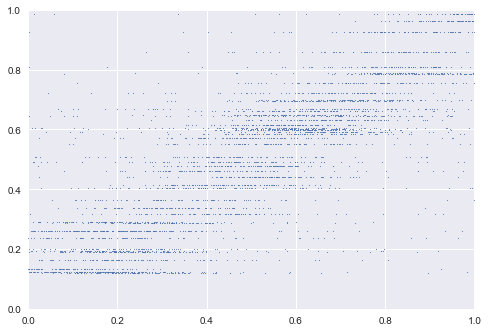

In [32]:
plt.scatter(train["x"][train["id"] < 50], train["y"][train["id"] < 50], s=0.5)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [20]:
cols_dnn = cols_orig

models_weights = {"dnn_1": 1}#, "dnn_2": 0.2, "dnn_3": 0.2,
                  #"dnn_4": 0.2, "dnn_5": 0.2}
models_cols = {"dnn_1": cols_dnn}
#models_cols = {"dnn_1": cols_dnn, "dnn_2": cols_dnn, "dnn_3": cols_dnn,
 #              "dnn_4": cols_dnn, "dnn_5": cols_dnn}
    
#learning_rate = 0.1

# Scoring function in the hyperopt hyperparameters tuning.
def scoring_function(parameters):
    print("Training the model with parameters: ")
    print(parameters)
    average_RMSE = 0.0
    n_splits = 5
    
    # Generate random integer for model_dir
    random_int = np.random.randint(1000)
    
    kf = KFold(n_splits=n_splits)
    nb_fold = 0
    for train_index, validation_index in kf.split(train):
        nb_fold += 1
        train_fold, validation_fold = train.loc[train_index], train.loc[validation_index]
        
        # Remove outliers
        #train_fold = train_fold[~train_fold["id"].isin(outliers_id)].reset_index(drop=True)

        feature_cols = [tf.contrib.layers.real_valued_column(k) for k in cols_dnn]
        
        count = 0
        model_dir = ("./log_"
                     + str(parameters["steps"]) + "_"
                     + str(parameters["nb_neurons_1"]) + "_"
                     #+ str(parameters["nb_neurons_2"])
                     + str(nb_fold) + "_"
                     + str(count) + "_"
                     + str(random_int)
                    )
        
        # Tune number of layers
        model_dnn = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols,
                                                  hidden_units=[parameters["nb_neurons_1"]],
                                                                #parameters["nb_neurons_2"]],
                                                  #optimizer=tf.train.ProximalAdagradOptimizer(
                                                   #   learning_rate=learning_rate,
                                                    #  l2_regularization_strength=parameters["l2_reg"]),
                                                  #dropout=parameters["dropout"],
                                                  model_dir=model_dir)

        def input_fn(data_set):
            feature_cols = {k: tf.constant(data_set[k].values) for k in cols_dnn}
            labels = tf.constant(data_set["y"].values)
            return feature_cols, labels
        
        model_dnn.fit(input_fn=lambda: input_fn(train_fold), steps=parameters["steps"])

        train_pred = train_fold[["id"]].assign(y_hat=0)
        #for i, m in models.items():
        temp = model_dnn.predict(input_fn=lambda: input_fn(train_fold))
        # .predict() returns an iterator; convert to an array
        y_hat = np.array(list(itertools.islice(temp, 0, None)))
        train_pred["y_hat"] = y_hat

        # Use median value by id
        y_hat_med = train_pred.groupby("id").median()["y_hat"].to_dict()

        RMSE = np.sqrt(mean_squared_error(train_pred["id"].map(y_hat_med).values, train_fold["y"]))
        
        # Prune outliers
        RMSE_decreasing = True
        while (RMSE_decreasing):
            count +=1
            train_pred["y_med"] = train_pred["id"].map(y_hat_med)

            # Distance from the median for each bag
            train_pred["score"] = (train_pred["y_hat"] - train_pred["y_med"])**2
            # Rank of each instance by bag
            train_pred["rank"] = train_pred.groupby("id")["score"].rank()
            bag_size_dict = train_pred.groupby("id")["score"].count().to_dict()
            train_pred["bag_size"] = train_pred["id"].map(bag_size_dict)
            train_pred["rank"] = train_pred["rank"] / train_pred["bag_size"]

            # Remove outliers
            outliers_index = train_pred["rank"] > (1 - parameters["outliers_threshold"])
            train_fold = train_fold.loc[~outliers_index, :].reset_index(drop=True)
            
            model_dir = ("./log_"
                         + str(parameters["steps"]) + "_"
                         + str(parameters["nb_neurons_1"]) + "_"
                         #+ str(parameters["nb_neurons_2"])
                         + str(nb_fold) + "_"
                         + str(count) + "_"
                         + str(random_int)
                        )

            model_dnn = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols,
                                                      hidden_units=[parameters["nb_neurons_1"]],
                                                                    #parameters["nb_neurons_2"]],
                                                      #optimizer=tf.train.ProximalAdagradOptimizer(
                                                       #   learning_rate=learning_rate,
                                                        #  l2_regularization_strength=parameters["l2_reg"]),
                                                      #dropout=parameters["dropout"],
                                                      model_dir=model_dir)

            model_dnn.fit(input_fn=lambda: input_fn(train_fold), steps=parameters["steps"])

            # Compute new RMSE
            train_pred = train_fold[["id"]].assign(y_hat=0)
            
            #for i, m in models.items():
            temp = model_dnn.predict(input_fn=lambda: input_fn(train_fold))
            # .predict() returns an iterator; convert to an array
            y_hat = np.array(list(itertools.islice(temp, 0, None)))
            train_pred["y_hat"] = y_hat

            # Use median value by id
            y_hat_med = train_pred.groupby("id").median()["y_hat"].to_dict()

            new_RMSE = np.sqrt(mean_squared_error(train_pred["id"].map(y_hat_med), train_fold["y"]))
            print("Pruning {0} RMSE: {1}".format(count, new_RMSE))
            
            #if (abs(new_RMSE - RMSE) > parameters["gain_threshold"]):
            # 5 iterations of pruning
            if (count < 5):
                RMSE = new_RMSE
            else:
                RMSE_decreasing = False
        
        # Bagging of RNN
        # Bootstrap 1
        train_fold_1 = train_fold
        model_dnn_1 = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols,
                                                    hidden_units=[parameters["nb_neurons_1"]])
                                                    #optimizer=tf.train.ProximalAdagradOptimizer(
                                                     #   learning_rate=learning_rate,
                                                      #  l2_regularization_strength=parameters["l2_reg"]),
                                                    #dropout=parameters["dropout"])
        model_dnn_1.fit(input_fn=lambda: input_fn(train_fold_1), steps=parameters["steps"])
        
        # Boostrap 2
        #train_fold_2 = resample(train_fold, random_state=random_seed).sort_values(by=["id"]).reset_index(drop=True)
        #model_dnn_2 = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols,
         #                                           hidden_units=[parameters["nb_neurons_1"]])
                                                    #model_dir=model_dir)
        #model_dnn_2.fit(input_fn=lambda: input_fn(train_fold_2), steps=parameters["steps"])
            
        # Bootstrap 3
        #train_fold_3 = resample(train_fold, random_state=(random_seed+1)).sort_values(by=["id"]).reset_index(drop=True)
        #model_dnn_3 = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols,
         #                                           hidden_units=[parameters["nb_neurons_1"]])
                                                    #model_dir=model_dir)
        #model_dnn_3.fit(input_fn=lambda: input_fn(train_fold_3), steps=parameters["steps"])
        
        # Bootstrap 4
        #train_fold_4 = resample(train_fold, random_state=(random_seed+2)).sort_values(by=["id"]).reset_index(drop=True)
        #model_dnn_4 = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols,
         #                                           hidden_units=[parameters["nb_neurons_1"]])
                                                    #model_dir=model_dir)
        #model_dnn_4.fit(input_fn=lambda: input_fn(train_fold_4), steps=parameters["steps"])
        
        # Bootstrap 5
        #train_fold_5 = resample(train_fold, random_state=(random_seed+3)).sort_values(by=["id"]).reset_index(drop=True)
        #model_dnn_5 = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols,
         #                                           hidden_units=[parameters["nb_neurons_1"]])
                                                    #model_dir=model_dir)
        #model_dnn_5.fit(input_fn=lambda: input_fn(train_fold_5), steps=parameters["steps"])
        
        # Changed to model_dnn instead of model_dnn_1
        models = {"dnn_1": model_dnn_1}#, "dnn_2": model_dnn_2, "dnn_3": model_dnn_3,
                  #"dnn_4": model_dnn_4, "dnn_5": model_dnn_5}
        
        # Compute RMSE on validation set
        validation_pred = validation_fold[["id"]].assign(y_hat=0).reset_index(drop=True)
        for i, m in models.items():
            temp = m.predict(input_fn=lambda: input_fn(validation_fold))
            # .predict() returns an iterator; convert to an array
            y_hat = np.array(list(itertools.islice(temp, 0, None)))
            validation_pred["y_hat"] += models_weights[i] * y_hat
            
        # Weight each instance by gaussian pdf
        #validation_pred = pdf_weight(validation_pred)
        # Use median value by id
        y_hat_med = validation_pred.groupby("id").median()["y_hat"].to_dict()
        
        #validation_pred["y_hat_weighted_sum"]
        #validation_fold["id"].map(y_hat_med).values
        RMSE = np.sqrt(mean_squared_error(validation_fold["id"].map(y_hat_med).values, validation_fold["y"]))
        average_RMSE += RMSE
        print("Validation fold {0} RMSE: {1}".format(nb_fold, RMSE))

    average_RMSE /= n_splits

    print("Cross-validation score: {0}\n".format(average_RMSE))
    
    return {"loss": average_RMSE, "status": STATUS_OK}

In [21]:
t0 = time()

# Grid to pick parameters from.
parameters_grid = {"steps"             : hp.choice("steps", np.arange(200, 300, 100, dtype=int)),
                   "nb_neurons_1"      : hp.choice("nb_neurons_1", np.arange(5, 6, 1, dtype=int)),
                   "outliers_threshold": hp.quniform("outliers_threshold", 0.05, 0.051, 0.01),
                   "gain_threshold"    : hp.quniform("gain_threshold", 0.01, 0.015, 0.005)
                   #"dropout": hp.quniform("dropout", 0.2, 0.4, 0.1)
                   #"l2_reg": hp.quniform("l2_reg", 0.00, 0.005, 0.01)
                   #"nb_neurons_2": hp.choice("nb_neurons_2", np.arange(5, 10, 1, dtype=int))
                  }
# Record the information about the cross-validation.
trials = Trials()

best = fmin(scoring_function, parameters_grid, algo=tpe.suggest, max_evals=1, 
            trials=trials)

computing_time = time() - t0

Training the model with parameters: 
{'gain_threshold': 0.015, 'steps': 200, 'nb_neurons_1': 5, 'outliers_threshold': 0.05}
Pruning 1 RMSE: 0.0886810443581
Pruning 2 RMSE: 0.0722942114824
Pruning 3 RMSE: 0.0648974855781
Pruning 4 RMSE: 0.0605885717853
Pruning 5 RMSE: 0.0576981808583
Validation fold 1 RMSE: 0.120492707218
Pruning 1 RMSE: 0.108541808739
Pruning 2 RMSE: 0.0971209489784
Pruning 3 RMSE: 0.0758067694882
Pruning 4 RMSE: 0.0622620046642
Pruning 5 RMSE: 0.0598145599841
Validation fold 2 RMSE: 0.0685860297627
Pruning 1 RMSE: 0.102133976829
Pruning 2 RMSE: 0.123614904986
Pruning 3 RMSE: 0.0701570350651
Pruning 4 RMSE: 0.0642020665995
Pruning 5 RMSE: 0.12123422232
Validation fold 3 RMSE: 0.0824906125714
Pruning 1 RMSE: 0.127372874343
Pruning 2 RMSE: 0.0726832843682
Pruning 3 RMSE: 0.0710290845374
Pruning 4 RMSE: 0.0875016379983
Pruning 5 RMSE: 0.0580327295165
Validation fold 4 RMSE: 0.0651261402836
Pruning 1 RMSE: 0.0900104792587
Pruning 2 RMSE: 0.0784343131342
Pruning 3 RMSE: 0.0

In [ ]:
Outlinear linear
Training the model with parameters: 
{'gain_threshold': 0.015, 'steps': 1000, 'nb_neurons_1': 11, 'outliers_threshold': 0.05}
Pruning 1 RMSE: 0.0804155030185
Pruning 2 RMSE: 0.0794809993989
Pruning 3 RMSE: 0.065860152061
Pruning 4 RMSE: 0.061603047503
Pruning 5 RMSE: 0.0586138764275
Validation fold 1 RMSE: 0.0617678059642
Pruning 1 RMSE: 0.0843172240725
Pruning 2 RMSE: 0.0748873140784
Pruning 3 RMSE: 0.065482659712
Pruning 4 RMSE: 0.0613644908284
Pruning 5 RMSE: 0.0609045015971
Validation fold 2 RMSE: 0.0673808018742
Pruning 1 RMSE: 0.0811678935522
Pruning 2 RMSE: 0.0772371483952
Pruning 3 RMSE: 0.0660389858725
Pruning 4 RMSE: 0.0614534539826
Pruning 5 RMSE: 0.059306412431
Validation fold 3 RMSE: 0.0600865575504
Pruning 1 RMSE: 0.0814326476057
Pruning 2 RMSE: 0.0719821617032
Pruning 3 RMSE: 0.0645202690828
Pruning 4 RMSE: 0.0598876604168
Pruning 5 RMSE: 0.0593301500914
Validation fold 4 RMSE: 0.0648812016439
Pruning 1 RMSE: 0.0810715252891
Pruning 2 RMSE: 0.0745169133733
Pruning 3 RMSE: 0.064487828201
Pruning 4 RMSE: 0.0617649969488
Pruning 5 RMSE: 0.0601317270497
Validation fold 5 RMSE: 0.0624430532392
Cross-validation score: 0.0633118840544

In [ ]:
MODIS train: 980 bags
Training the model with parameters: 
{'gain_threshold': 0.01, 'steps': 900, 'nb_neurons_1': 9, 'outliers_threshold': 0.05}
Pruning 1 RMSE: 0.105343361018
Validation fold 1 RMSE: 0.0987015791108
Pruning 1 RMSE: 0.100121169819
Pruning 2 RMSE: 0.0939525682587
Validation fold 2 RMSE: 0.139847916988
Pruning 1 RMSE: 0.121320922084
Pruning 2 RMSE: 0.111532420256
Validation fold 3 RMSE: 0.13168961676
Pruning 1 RMSE: 0.10949595882
Pruning 2 RMSE: 0.103120828612
Validation fold 4 RMSE: 0.107883013046
Pruning 1 RMSE: 0.112995428702
Validation fold 5 RMSE: 0.188379683693
Cross-validation score: 0.13330036192

In [ ]:
MODIS train: 1364 bags
    
Training the model with parameters: 
{'gain_threshold': 0.015, 'steps': 900, 'nb_neurons_1': 11, 'outliers_threshold': 0.05}
Pruning 1 RMSE: 0.119817931796
Validation fold 1 RMSE: 0.111377722376
Pruning 1 RMSE: 0.112396098948
Pruning 2 RMSE: 0.101808581135
Validation fold 2 RMSE: 0.148817162914
Pruning 1 RMSE: 0.115222994126
Pruning 2 RMSE: 0.108615616905
Validation fold 3 RMSE: 0.110455499827
Pruning 1 RMSE: 0.111609881409
Validation fold 4 RMSE: 0.158362010857
Pruning 1 RMSE: 0.108284906653
Validation fold 5 RMSE: 0.120915922243
Cross-validation score: 0.129985663643


In [ ]:
1 DNN

Training the model with parameters: 
{'gain_threshold': 0.01, 'steps': 900, 'nb_neurons_1': 11, 'outliers_threshold': 0.05}
Pruning 1 RMSE: 0.720018452178
Pruning 2 RMSE: 0.694637808863
Pruning 3 RMSE: 0.682604548885
Pruning 4 RMSE: 0.675240927353
Validation fold 1 RMSE: 0.657330001629
Pruning 1 RMSE: 0.67466681128
Pruning 2 RMSE: 0.65951277037
Pruning 3 RMSE: 0.649785148888
Validation fold 2 RMSE: 0.748604123648
Pruning 1 RMSE: 0.68920733019
Pruning 2 RMSE: 0.673928761686
Pruning 3 RMSE: 0.663794898173
Pruning 4 RMSE: 0.656852425765
Validation fold 3 RMSE: 0.75238232566
Pruning 1 RMSE: 0.695945822399
Pruning 2 RMSE: 0.677436347483
Pruning 3 RMSE: 0.667360192164
Pruning 4 RMSE: 0.661270048569
Validation fold 4 RMSE: 0.703611985649
Pruning 1 RMSE: 0.675491954494
Pruning 2 RMSE: 0.654833366872
Pruning 3 RMSE: 0.641692836958
Pruning 4 RMSE: 0.633366415513
Validation fold 5 RMSE: 0.784596896669
Cross-validation score: 0.729305066651


In [42]:
min(trials.losses())

0.6523287945244072

In [43]:
# Save the best parameters as a csv.
best_parameters = pd.DataFrame({key: [value] for (key, value) in 
                                zip(space_eval(parameters_grid, best).keys(),
                                    space_eval(parameters_grid, best).values())})
# Add the corresponding score.
best_parameters["score"] = min(trials.losses())
best_parameters.to_csv("best_parameters_7.csv", encoding="utf-8", index=False)

best_parameters

,gain_threshold,nb_neurons_1,outliers_threshold,steps,score
0,0.0075,10,0.05,900,0.652329


### Training models

In [8]:
cols_dnn = cols_orig
models_weights = {"dnn_1": 1.0}
models_cols = {"dnn_1": cols_dnn}
best_parameters = pd.read_csv("best_parameters_6.csv", encoding="utf-8")
model_dir = "./log_submit_6"

feature_cols = [tf.contrib.layers.real_valued_column(k) for k in cols_dnn]
        
# Tune number of layers
model_dnn = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols,
                                          hidden_units=[best_parameters["nb_neurons_1"][0]],
                                          model_dir=model_dir)

def input_fn(data_set):
    feature_cols = {k: tf.constant(data_set[k].values) for k in cols_dnn}
    labels = tf.constant(data_set["y"].values)
    return feature_cols, labels

model_dnn.fit(input_fn=lambda: input_fn(train), steps=best_parameters["steps"][0])
        
train_pred = train[["id"]].assign(y_hat=0)
temp = model_dnn.predict(input_fn=lambda: input_fn(train))
# .predict() returns an iterator; convert to an array
y_hat = np.array(list(itertools.islice(temp, 0, None)))
train_pred["y_hat"] = y_hat

# Use median value by id
y_hat_med = train_pred.groupby("id").median()["y_hat"].to_dict()

RMSE = np.sqrt(mean_squared_error(train_pred["id"].map(y_hat_med).values, train["y"]))
        
# Prune outliers
RMSE_decreasing = True
count = 0
while (RMSE_decreasing):
    count += 1
    train_pred["y_med"] = train_pred["id"].map(y_hat_med)

    # Distance from the median for each bag
    train_pred["score"] = (train_pred["y_hat"] - train_pred["y_med"])**2
    # Rank of each instance by bag
    train_pred["rank"] = train_pred.groupby("id")["score"].rank()
    bag_size_dict = train_pred.groupby("id")["score"].count().to_dict()
    train_pred["bag_size"] = train_pred["id"].map(bag_size_dict)
    train_pred["rank"] = train_pred["rank"] / train_pred["bag_size"]

    # Remove outliers
    outliers_index = train_pred["rank"] > (1 - best_parameters["outliers_threshold"][0])
    train = train.loc[~outliers_index, :].reset_index(drop=True)

    model_dnn = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols,
                                              hidden_units=[best_parameters["nb_neurons_1"][0]],
                                              model_dir=model_dir)

    model_dnn.fit(input_fn=lambda: input_fn(train), steps=best_parameters["steps"][0])

    # Compute new RMSE
    train_pred = train[["id"]].assign(y_hat=0)
            
    temp = model_dnn.predict(input_fn=lambda: input_fn(train))
    # .predict() returns an iterator; convert to an array
    y_hat = np.array(list(itertools.islice(temp, 0, None)))
    train_pred["y_hat"] = y_hat

    # Use median value by id
    y_hat_med = train_pred.groupby("id").median()["y_hat"].to_dict()

    new_RMSE = np.sqrt(mean_squared_error(train_pred["id"].map(y_hat_med), train["y"]))
    print("Pruning {0} RMSE: {1}".format(count, new_RMSE))

    if (abs(new_RMSE - RMSE) > best_parameters["gain_threshold"][0]):
        RMSE = new_RMSE
    else:
        RMSE_decreasing = False
        
# Training model
model_dnn_1 = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols,
                                            hidden_units=[best_parameters["nb_neurons_1"][0]])
model_dnn_1.fit(input_fn=lambda: input_fn(train), steps=best_parameters["steps"][0])

models = {"dnn_1": model_dnn_1}

Pruning 1 RMSE: 0.623854414971
Pruning 2 RMSE: 0.612112933147
Pruning 3 RMSE: 0.605667733108


### Predicting on test set

In [9]:
test_pred = test[["id"]].assign(y_hat=0).reset_index(drop=True)
for i, m in models.items():
    temp = m.predict(input_fn=lambda: input_fn(test))
    # .predict() returns an iterator; convert to an array
    y_hat = np.array(list(itertools.islice(temp, 0, None)))
    test_pred["y_hat"] += models_weights[i] * y_hat

# Use median value by id
y_hat_med = test_pred.groupby("id").median()["y_hat"]

In [10]:
RMSE = np.sqrt(mean_squared_error(test_pred["id"].map(y_hat_med).values, test["y"]))
RMSE
#0.65725435012348465 for Pred 4
#0.65362864377856866 for Pred 5

0.71423164615804291

In [11]:
kaggle_pred = pd.DataFrame({"Id": y_hat_med.index, "y": y_hat_med.values})
kaggle_pred.to_csv("Prediction_6.csv", encoding="utf-8", index=False)

### Benchmark:
* Submit 1 (ensemble of xgboost + 2 ridge with instances model)
eta	eval_metric	gamma	lambda	max_depth	min_child_weight	nthread	objective	seed	silent	subsample	score
0.91834 Public LB 300 trees 0.09	rmse	0.2	0.8	4	4.0	-1	reg:linear	22	0	0.7	0.883339 (cross-val)
    
* Submit 2

Pruning with linear regression
then add contributions of aggregated xgboost + linear model

0.78181 Public LB  0.779345 CV

* Submit 3
DNN pruning
(wrong CV)
0.73270 Public LB 0.663128 CV with DNN 10 neurons 900 steps gain_threshold = 0.01 outliers_threshold = 0.05

* Prediction 4
LB 0.74713
Ensemble of 5 DNN
{'gain_threshold': 0.015, 'steps': 3800, 'nb_neurons_1': 10, 'outliers_threshold': 0.05} CV 0.701658836521
using fist pruning DNN
* Prediction 5
LB 0.74453
Ensemble of 5 DNN
{'gain_threshold': 0.01, 'steps': 2400, 'nb_neurons_1': 10, 'outliers_threshold': 0.05} CV 0.707300896236

In [ ]:
Dropout
L2 regu
Validation set instead of cross val

### EM algorithm

In [ ]:
def gamma_i_j(j, pi_i, X_i, y_i, delta):
    out = 0.0
    out = pi_i[j] * norm.pdf(y_i, X_i[j], delta)
    out /= sum(pi_i * norm.pdf(y_i, X_i, delta))
    return(out)

def EM_Q(pi, X, y, delta):
    
    
    

cols_dnn = cols_orig

best_parameters = pd.read_csv("best_parameters_6.csv", encoding="utf-8")

feature_cols = [tf.contrib.layers.real_valued_column(k) for k in cols_dnn]

model_dir_f = "./log_submit_6"

# Fit DNN regressor
model_dnn_f = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols,
                                            hidden_units=[best_parameters["nb_neurons_f"][0]],
                                            model_dir=model_dir_f)

def input_fn(data_set):
    feature_cols = {k: tf.constant(data_set[k].values) for k in cols_dnn}
    labels = tf.constant(data_set["y"].values)
    return feature_cols, labels

model_dnn_f.fit(input_fn=lambda: input_fn(train), steps=best_parameters["steps_f"][0])

# Train prediction
train_pred = train[["id"]].assign(y_hat=0, pi_hat=0)
temp = model_dnn_f.predict(input_fn=lambda: input_fn(train))
y_hat = np.array(list(itertools.islice(temp, 0, None)))
train_pred["y_hat"] = y_hat

# Fit DNN softmax
model_dir_g = "./g_log_EM"
model_dnn_g = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols,
                                            hidden_units=[best_parameters["nb_neurons_g"][0]],
                                            model_dir=model_dir_g)

model_dnn_g.fit(input_fn=lambda: input_fn(train), steps=best_parameters["steps_g"][0])
temp = model_dnn_g.predict(input_fn=lambda: input_fn(train))
pi_hat = np.array(list(itertools.islice(temp, 0, None)))

# Compute softmax
train_pred["pi_hat"] = np.exp(pi_hat)
pi_hat_sum_dict = train_pred.groupby("id")["pi_hat"].sum().to_dict()
# "map" is actually much faster than "replace"
train_pred["pi_hat_sum"] = train_pred["id"].map(pi_hat_sum_dict)
train_pred["pi_hat"] /= train_pred["pi_hat_sum"]

# EM algorithm
# Change to Q
EM_decreasing = True
nb_iteration = 0
while (EM_decreasing):
    nb_iteration +=1

    model_dnn = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols,
                                              hidden_units=[best_parameters["nb_neurons_f"][0]],
                                              model_dir=model_dir)

    model_dnn.fit(input_fn=lambda: input_fn(train), steps=best_parameters["steps_f"][0])

    # Compute new RMSE
    train_pred = train[["id"]].assign(y_hat=0)
            
    temp = model_dnn.predict(input_fn=lambda: input_fn(train))
    # .predict() returns an iterator; convert to an array
    y_hat = np.array(list(itertools.islice(temp, 0, None)))
    train_pred["y_hat"] = y_hat


    print("Iteration {0} EM: {1}".format(nb_iteration, new_RMSE))

    if (abs(new_RMSE - RMSE) > 0.1):
        RMSE = new_RMSE
    else:
        EM_decreasing = False

models = {"dnn_1": model_dnn}